<a href="https://colab.research.google.com/github/yesiltepe-hidir/GAN/blob/main/DCGAN/DCGAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Network (DCGAN)

🏸 This notebook implements the paper using `PyTorch`. For `Tensorflow` implementation please follow the link: [Tensorflow implementation](https://www.tensorflow.org/tutorials/generative/dcgan).

DCGAN Tutorial
==============
**Authored by:** [Hıdır Yeşiltepe](https://https://github.com/yesiltepe-hidir)

**Created:** 04.05.2022

**Last Modified:** 05.05.2022

Introduction
------------
🔑 This tutorial will give you a hands-on experience on GAN implementation. We will first give a high level look at the Generative Modelling and  Generative Adversarial Networks and their objective function. Then, we will implement the [DCGAN paper](https://https://arxiv.org/pdf/1511.06434.pdf).


Generative Modelling
--------------------------------
Let's start with explaining the core question:
~~~~~~~~~~~
What is Generative Modelling? 
~~~~~~~~~~~~

Generative models can be divided into 3 main categories by the time this notebook is created:
1. <font color='black'>**Variational Autoencoders (VAEs)**</font>
2. <font color ='black'>**Generative Adversarial Networks (GANs)** </font>
3. <font color ='black'>**Normalizing Flow Models (NFM)**</font>

🔓 Generative modelling is an unsupervised learning which aims to find the distribution of the data such that new hyper-realistic datapoints can be generated. 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Why does learning the data distribution matter?
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
🔓 There exists abundant amount of unlabeled data compared to labeled ones. If we could learn the distribution of given data, we can indeed conditionally generate new, hyper-realistic datapoints and label them for free. Below you can see significant applications of learning underlying data distribution.

1. <font color='black'>**Density Estimation:** </font> One of the most important applications of generative modelling is estimating the probability density function for continous random variables and probability mass function for discrete random variables. With the help of probability densities we can comment on certain events based on their probabilities. Unfortunately, none of the <font color='pink'> GANs </font> and <font color='pink'> VAEs </font> can be used for density estimation since traditionally they don't structured to retrieve explicit probability densities although they learn it implicitly. <font color='pink'>Normalizing flows</font>, on the other hand, can learn the probability densities explicitly by applying successive change of variables technique.
2. <font color='black'>**Synthesis and Sampling:** </font> The other application of generative modelling is generating datasets based on the trained dataset. After learning the distribution of the data implicitly or explicitly, at the inference time, we can sample from learned distribution and synthesize new datapoints (e.g images, text, video snapshots, bathrooms etc.)
3. <font color='black'>**Denoising:**</font> Generative modelling can also be applied to tasks such as improving the quality of old images such as images from World War II. This task, of course, needs to learn underlying probability distribution of images from the dataset and mapping low resolution - missing part - damaged image to high resolution image.

Generative Adversarial Networks
--------------------------------
~~~~~~~~~~~~~~
What is a GAN?
~~~~~~~~~~~~~~
Generative Adversarial Networks (GANs), are invented by Ian Goodfellow in 2014 with the  [NeurIPS paper.](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf) GANs contain two network that try to outwit each other in a clever way. The main 2 component of GANs are <font color='orange'> Generator </font> which aims at generating datapoints (e.g images) that are indistinguishable from the real ones contained in the dataset, and <font color='yellow'> Discriminator </font> whose responsibility is to discern the fake images from the real ones. Indeed, GANs can be thought of as a minimax game where <font color='orange'> Generator </font> tries to maximize the probability of fake datapoints being close to real ones and <font color='yellow'> Discriminator </font> tries to minimize the probability of fake datapoints being labeled as real.

- In the case of image generation, <font color='orange'> Generator </font> takes a random low dimensional latent variable as an input and produce higher dimensional output which turns out to be a fake image when we reshape it. 

- <font color='yellow'> Discriminator </font>, on the other hand, takes fake images and real images from the dataset and use them to classify whether fake images come from the same distribution of the real images. The output of the <font color='yellow'> Discriminator </font> is a scalar: probability of fake images being close to the images in the dataset.

The equilibrium of this zero-sum game is achieved when <font color='yellow'> Discriminator </font> can not distinguish the fake images from the real ones further and flip a coin (by 50% chance it label fake images as real and 50% chance it labels it as fake). 

Formal Definition of GAN
--------------------------------
Let's define Discriminator and Generator formally.


* Let $X = \{x^{(1)}, ... x^{(n)}\}$ be our dataset with $x^{(i)}$ being the individual datapoints. We will denote the <font color='yellow'> Discriminator </font> output with $D(x, \hat x)$ which takes real images $x$ and fake images produced by <font color='orange'> Generator </font> $\hat x$ and outputs a scalar which is a probability of  $\hat x$ being  similar to $x$. In case of implementation details, the input $\hat x$ is image of shape HWC 64 x 64 x 3. 

* Generator takes a latent code $z$ as an input which is sampled from a tractable distribution (often Standard Normal Distribution). Let $G(z)$ represent the output of the <font color='orange'> Generator </font> which maps the latent code $z$ to a image of size HWC 64 x 64 x 3. The overall purpose of <font color='orange'> Generator </font> is estimating the probability distribution of the training data such that when $G(z)$ if fed to <font color='Yellow'> Discriminator</font>, it can no longer distinguish the fake images from the real ones.

As stated earlier, Generator and Discriminator plays a minimax game. The objective function of this game is given by:

\begin{align}
\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(x)))\big]
\end{align}

## Paper Overview

* This paper is written by Alec Radford & Luke Metz and Soumith Chintala.
* The main purpose of the paper is bridging the gap between success of CNNs for supersvised learning and unsupervised learning. CNNs performed very well on supervised learning tasks but is used rarely on unsupervised task until 2016.

With DCGAN paper following contributions are made:

~~~~
1. Proposing and evaluating set of constraints on the architectural topology of CNN GANs. 
2. Training pretrained `Discriminators` for image classification tasks which shows a competitive performance with other unsupervised algorithms.
3. Visualizing the filters learned by GAN. Further, they show that specific filters are learned to draw specific objects.
~~~~~

## Architecural Guidelines

This part of the notebook corresponds to the section 3 in the original paper. Authors discuss the design for stable training and core to the trends used in state-of-the art CNN models.

~~~~
1. Replace any pooling layer with strided convolutions (discriminator), and fractional strided convolutions (generator).
2. Use batch-norm in both generator and discriminator.
3. Remove fully-connected layers for deeper architectures.
4. Use ReLU activation function for all layers except the for the output which uses Tanh.
5. Use LeakyReLU activation in the discriminator for all layers.
~~~~~

## Import Dependencies

In [ ]:
# Import Dependencies
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)

## Configurations

In [ ]:
# Root for the data
data_root = 'data'
# Number of workers for dataloader
workers = 4
# Batch size during training
batch_size = 128
# Spatial size of the images -> All images will be resized to this size using a transformer
image_size = 64
# Number of channels
nc = 3
# Size of the latent vector
nz = 100
# Size of feature maps in Generator
ngf = 64
# Size of feature maps in Discriminator
ndf = 64
# Number of trainin epochs
n_epochs = 15
# Learning rate
lr = 0.0002
# Beta1 hyperparameter for Adam Optimizer
beta1 = 0.5
# Number of GPUs available
ngpu = 1

## Data

In [ ]:
import os

In [ ]:
!rm -rf data
!wget https://s3.amazonaws.com/pytorch-tutorial-assets/img_align_celeba.zip -P data
!unzip -qq data/img_align_celeba.zip -d data/
!ls -l data/img_align_celeba | wc -l

--2022-05-05 20:59:06--  https://s3.amazonaws.com/pytorch-tutorial-assets/img_align_celeba.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.132.5
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.132.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘data/img_align_celeba.zip’

img_align_celeba.zi 100%[===================>]   1.34G  13.4MB/s    in 1m 43s  

2022-05-05 21:00:50 (13.3 MB/s) - ‘data/img_align_celeba.zip’ saved [1443490838/1443490838]

202600


In [ ]:
len(os.listdir('data/img_align_celeba'))

202599

In [ ]:
# We can use an image folder dataset the way we set it up. Create the dataset
dataset = dset.ImageFolder(
          root=data_root,
          transform=transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(
             dataset,
             batch_size=batch_size,
             shuffle=True,
             num_workers=workers)

# Set the device
device = torch.device('cuda:0' if torch.cuda.is_available() and ngpu>0 else 'cpu');

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Set the batch
real_batch = next(iter(dataloader));

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


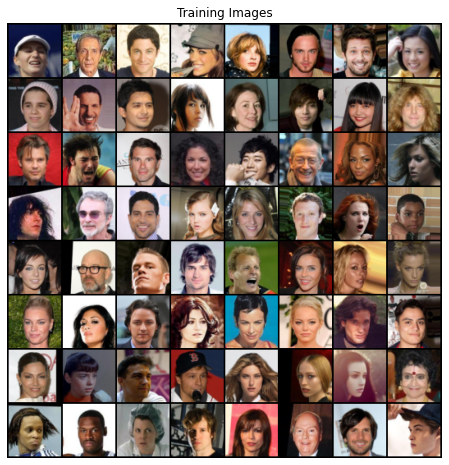

In [ ]:
# Plot some training images
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)));

## Weight Initialization

From DCGAN paper, the authors specify that all model weights should be randomly initialized from a Normal distribution with `mean = 0` and `standard deviation = 0.02`. The `weights_init` function takes an initialized model as input and reinitializes all `Convolutional`, `Convolutional-Transpose` and `Batch Normalization Layers` to meet this criteria. This function is applied to the models immediately after initialization.

In [ ]:
# Custom weight initialization called on Generator network and Discriminator network
def weights_init(model):
  classname = model.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(model.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(model.weight.data, 1.0, 0.02)
    nn.init.constant_(model.bias.data, 0)

## Generator Network

In [ ]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
          # input is latent vector Z, going into transpose convolution
          nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
          nn.BatchNorm2d(ngf * 8),
          nn.ReLU(True),
          # State size: (ngf * 8) x 4 x 4
          nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf * 4),
          nn.ReLU(True),
          # State size: (ngf * 4) x 8 x 8
          nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf * 2),
          nn.ReLU(True),
          # State size: (ngf * 2) x 16 x 16
          nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
          # State size: (ngf) x 32 x 32
          nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
          # State size: (nc) x 64 x 64
    )

  def forward(self, input):
    return self.main(input)

In [ ]:
# Create generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply weigth initialization
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Discriminator Network

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # input is image of size (nc) x 64 x 64
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # State size: (ndf) x 32 x 32
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # State size: (ndf * 2) x 16 x 16
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # State size: (ndf * 4) x 8 x 8
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),
        # State size: (ndf * 8) x 4 x 4
        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
    return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda' and ngpu > 1):
  netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply weight initialization
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Loss Functions and Optimizers

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Set up Adam optimizers for Generator and Discriminator
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(n_epochs):
  for i, data in enumerate(dataloader, 0):
    # ---------- Discriminator Network ------------ #

    # Update Discriminator Network: maximize log(D(x)) + log(1 - D(G(z)))
    
    # Train with all-real batch
    netD.zero_grad()
    # Format batch
    real_img = data[0].to(device)
    b_size = real_img.size(0)
    # Set the label
    label = torch.full((b_size,), real_label, dtype=torch.float32, device=device)
    # Forward pass: Real batch through D
    output = netD(real_img).view(-1)
    # Calculate the loss on all-real batch
    errD_real = criterion(output, label)
    # Calculate the gradients for Discriminator in backward pass
    errD_real.backward()
    D_x = output.mean().item()

    
    # Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # Generate fake image batch with Generator
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all-fake batch with Discriminator
    output = netD(fake.detach()).view(-1)
    # Calculate Discriminator loss on the all-fake batch
    errD_fake = criterion(output, label)
    # Calculate gradients for this batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # Add gradients
    errD = errD_real + errD_fake
    # Update Discriminator
    optimizerD.step()


    # ---------- Generator Network ------------ #

    # Update Generator Network: maximize log(D(G(z)))
    netG.zero_grad()
    label.fill_(real_label) # Note that, fake labels are real for generator cost
    # Since we updated Discriminator network perform another forward pass
    output = netD(fake).view(-1)
    # Calculate Generator loss
    errG = criterion(output, label)
    # Calculate gradients
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update Generator
    optimizerG.step()

    # Output training stats
    if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, n_epochs, i, len(dataloader),
                  errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # Check how the generator is doing by saving Generator's output on fixed_noise
    if (iters % 500 == 0) or (epoch == n_epochs -1 and i == len(dataloader) - 1):
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
      img_list.append(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1,2,0)))

    iters += 1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[0/15][0/1583]	Loss_D: 2.1123	Loss_G: 6.9230	D(x): 0.7746	D(G(z)): 0.7816 / 0.0017
[0/15][50/1583]	Loss_D: 0.2017	Loss_G: 22.1429	D(x): 0.9331	D(G(z)): 0.0000 / 0.0000
[0/15][100/1583]	Loss_D: 1.4475	Loss_G: 6.0520	D(x): 0.5301	D(G(z)): 0.0004 / 0.0058
[0/15][150/1583]	Loss_D: 0.5174	Loss_G: 4.5282	D(x): 0.8122	D(G(z)): 0.2030 / 0.0172
[0/15][200/1583]	Loss_D: 0.4583	Loss_G: 5.9392	D(x): 0.7685	D(G(z)): 0.0208 / 0.0189
[0/15][250/1583]	Loss_D: 1.0604	Loss_G: 2.7377	D(x): 0.4873	D(G(z)): 0.0102 / 0.0994
[0/15][300/1583]	Loss_D: 0.6175	Loss_G: 5.9873	D(x): 0.9147	D(G(z)): 0.3463 / 0.0067
[0/15][350/1583]	Loss_D: 0.5057	Loss_G: 5.1988	D(x): 0.8834	D(G(z)): 0.2794 / 0.0113
[0/15][400/1583]	Loss_D: 0.5902	Loss_G: 3.0305	D(x): 0.6646	D(G(z)): 0.0381 / 0.0853
[0/15][450/1583]	Loss_D: 0.4125	Loss_G: 3.9898	D(x): 0.8808	D(G(z)): 0.2100 / 0.0340
[0/15][500/1583]	Loss_D: 0.7131	Loss_G: 6.6858	D(x): 0.9359	D(G(z)): 0.3898 / 0.0042
[0/15][550/1583]	Loss_D: 0.4021	Loss_G: 6.0654	D(x): 0.8871	D(G(z))

## Results

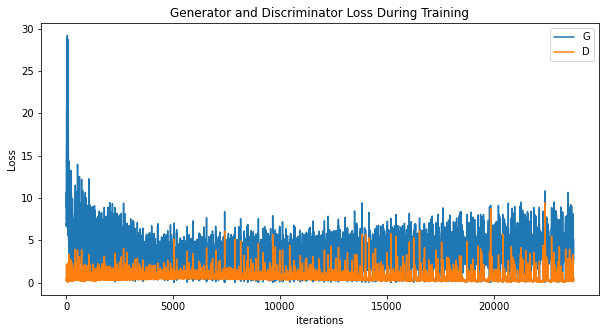

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [ ]:
# %%capture
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(i, animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

### Real Images vs Fake Images

Finally, let's take a look at some real images and fake images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


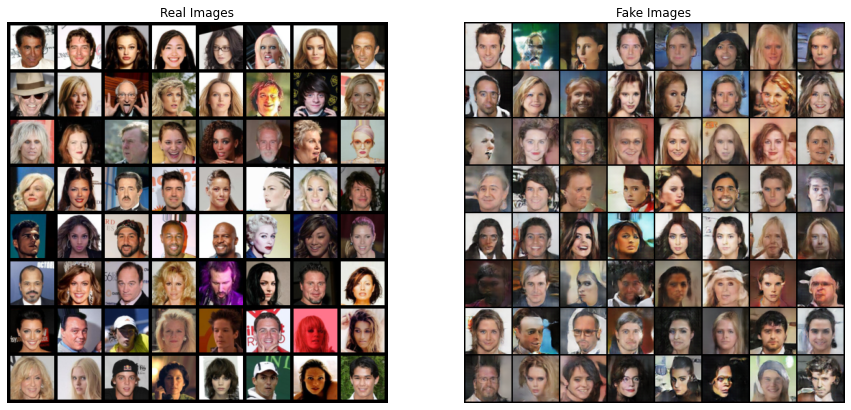

In [ ]:
# Grab a batch of real images
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize= (15, 15))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Real Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

# Plot the fake images
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Fake Images')
plt.imshow(img_list[-1])

plt.show();

In [ ]:
len(img_list)

49